In [1]:
import pandas as pd
import numpy as np

# Step 1: Load the datasets
mat = pd.read_csv("student-mat.csv", sep=";")
por = pd.read_csv("student-por.csv", sep=";")

# Step 2: Define merge keys (as in R code)
merge_keys = ["school", "sex", "age", "address", "famsize", "Pstatus", 
              "Medu", "Fedu", "Mjob", "Fjob", "reason", "nursery", "internet"]

# Step 3: Merge datasets on these keys
merged = pd.merge(mat, por, on=merge_keys, suffixes=('_mat', '_por'))

# Step 4: Identify and drop duplicated columns (all columns that appear as col_mat and col_por and are not G1/G2/G3)
subject_dependent = [
    "G1", "G2", "G3",
    "failures", "paid", "absences", "schoolsup", "studytime", "famsup"
]
all_cols = set(col[:-4] for col in merged.columns if col.endswith('_mat') or col.endswith('_por'))
duplicate_cols = [col for col in all_cols if col not in subject_dependent]

# Drop the _por version of duplicated columns (keep _mat or vice versa)
for col in duplicate_cols:
    por_col = f"{col}_por"
    if por_col in merged.columns:
        merged.drop(columns=por_col, inplace=True)

# Rename the _mat columns back to original names (if desired) — except for grades
for col in duplicate_cols:
    mat_col = f"{col}_mat"
    if mat_col in merged.columns:
        merged.rename(columns={mat_col: col}, inplace=True)


# Step 7: Save result
#merged.to_csv("student-merged-clean.csv", index=False)
#print("✅ Final dataset saved to 'student-merged-clean.csv'")


def simulate_dropout(row):
    risk_score = 0

    # Academic risk
    risk_score += 1 if row['G3_mat'] < 8 or row['G3_por'] < 8 else 0
    risk_score += 1 if row['failures_mat'] > 0 or row['failures_por'] > 0 else 0
    risk_score += 1 if row['studytime_mat'] < 2 or row['studytime_por'] < 2 else 0
    risk_score += 1 if row['absences_mat'] > 10 or row['absences_por'] > 10 else 0
    risk_score += 1 if row['higher'] == 'no' else 0

    # Support-related
    risk_score += 1 if row['famsup_mat'] == 'no' or row['famsup_por'] == 'no' else 0
    risk_score += 1 if row['schoolsup_mat'] == 'yes' or row['schoolsup_por'] == 'yes' else 0  # Needing support might indicate struggles

    # Social behavior
    risk_score += 1 if row['romantic'] == 'yes' else 0
    risk_score += 1 if row['goout'] >= 4 else 0

    # Risk behavior
    risk_score += 1 if row['Dalc'] >= 3 else 0
    risk_score += 1 if row['Walc'] >= 3 else 0

    # Health
    risk_score += 1 if row['health'] <= 2 else 0

    # Determine dropout likelihood
    if risk_score >= 6:
        return np.random.choice([1, 0], p=[0.9, 0.1])
    elif risk_score >= 4:
        return np.random.choice([1, 0], p=[0.6, 0.4])
    elif risk_score >= 2:
        return np.random.choice([1, 0], p=[0.3, 0.7])
    else:
        return np.random.choice([1, 0], p=[0.1, 0.9])
    
merged['dropout'] = merged.apply(simulate_dropout, axis=1)

# Step: Add unique student ID
merged["student_id"] = merged.index + 1

# --- Step 7: Reorder columns to move student_id to the first column ---
cols = ['student_id'] + [col for col in merged.columns if col != 'student_id']
merged = merged[cols]

# Step: Save the final datasets
merged.to_csv("student-dropout-fixed.csv", index=False)
print("✅ Data cleaned and saved to 'student-dropout-fixed.csv'")

✅ Data cleaned and saved to 'student-dropout-fixed.csv'


In [3]:
df = pd.read_csv("student-dropout-fixed.csv")  # ✅ Updated to fixed version

# Structure and quick look
df.info()
df.describe()
df["dropout"].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   student_id     382 non-null    int64 
 1   school         382 non-null    object
 2   sex            382 non-null    object
 3   age            382 non-null    int64 
 4   address        382 non-null    object
 5   famsize        382 non-null    object
 6   Pstatus        382 non-null    object
 7   Medu           382 non-null    int64 
 8   Fedu           382 non-null    int64 
 9   Mjob           382 non-null    object
 10  Fjob           382 non-null    object
 11  reason         382 non-null    object
 12  guardian       382 non-null    object
 13  traveltime     382 non-null    int64 
 14  studytime_mat  382 non-null    int64 
 15  failures_mat   382 non-null    int64 
 16  schoolsup_mat  382 non-null    object
 17  famsup_mat     382 non-null    object
 18  paid_mat       382 non-null   

dropout
0    0.594241
1    0.405759
Name: proportion, dtype: float64

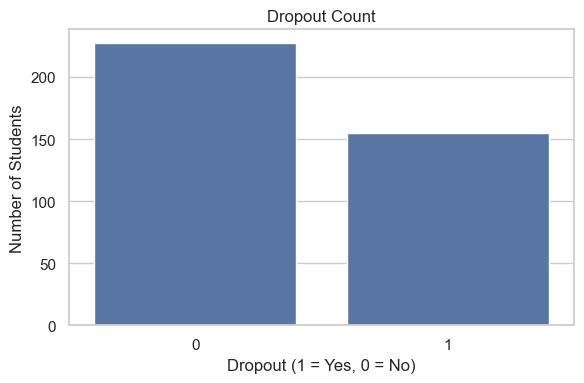

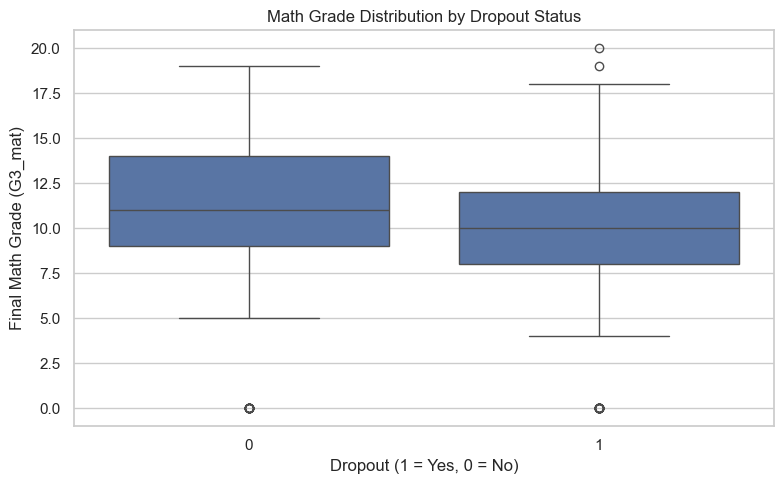

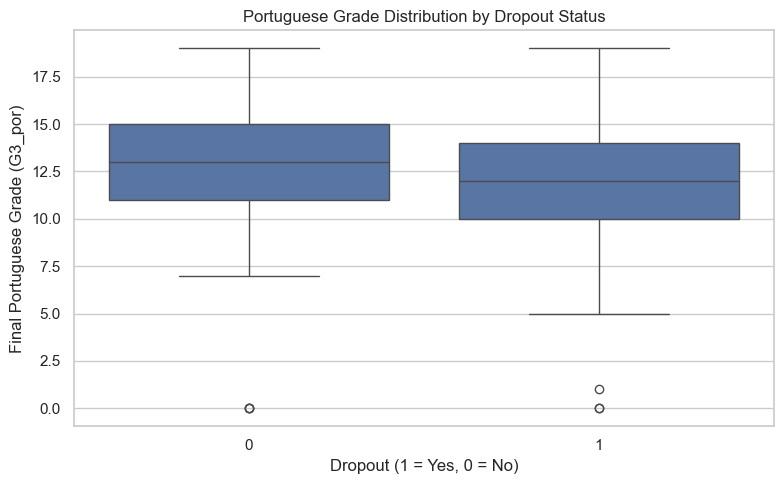

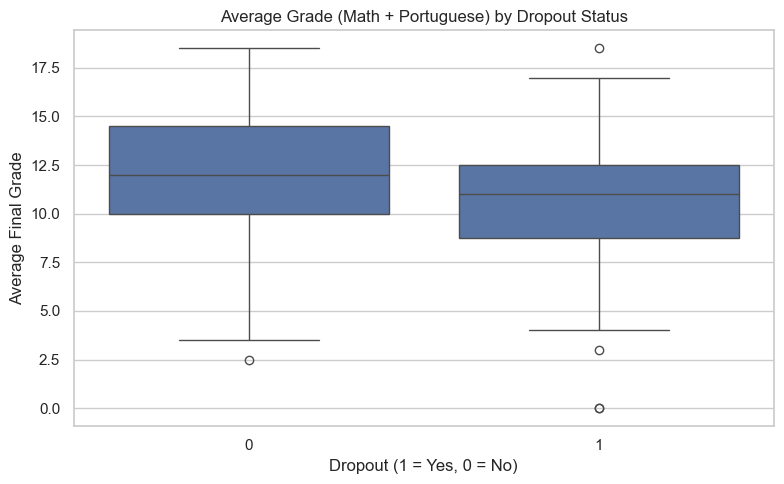

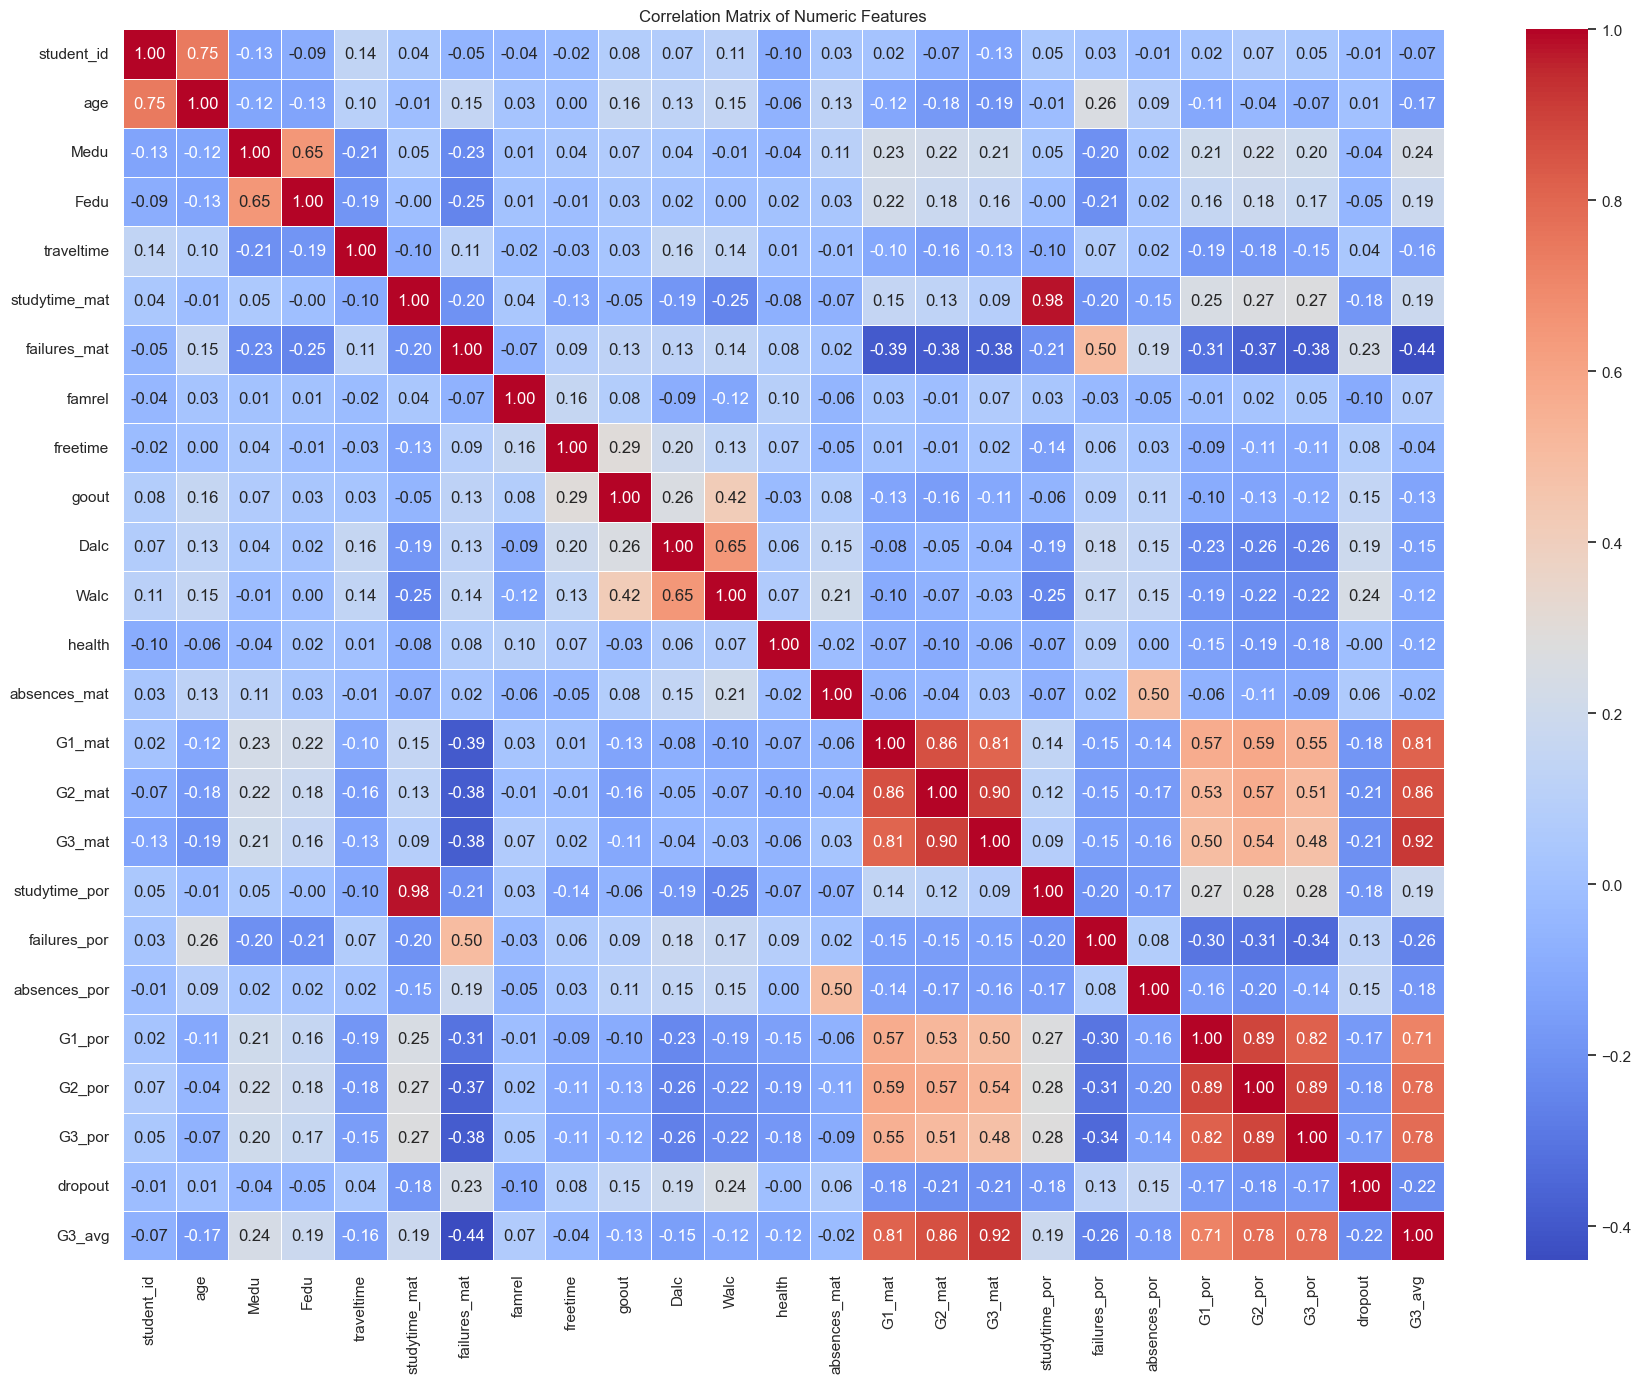

In [5]:
## Eve: dropping student_id if present

import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
os.makedirs("eda_plots", exist_ok=True)

# Use a clean visual style
sns.set(style="whitegrid")

# --- Plot 1: Count of Dropouts vs Non-Dropouts ---
plt.figure(figsize=(6, 4))
sns.countplot(x="dropout", data=df)
plt.title("Dropout Count")
plt.xlabel("Dropout (1 = Yes, 0 = No)")
plt.ylabel("Number of Students")
plt.tight_layout()
plt.savefig("eda_plots/dropout_count.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 2: Final Math Grade Distribution by Dropout ---
plt.figure(figsize=(8, 5))
sns.boxplot(x="dropout", y="G3_mat", data=df)
plt.title("Math Grade Distribution by Dropout Status")
plt.xlabel("Dropout (1 = Yes, 0 = No)")
plt.ylabel("Final Math Grade (G3_mat)")
plt.tight_layout()
plt.savefig("eda_plots/math_grade_vs_dropout.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 3: Final Portuguese Grade Distribution by Dropout ---
plt.figure(figsize=(8, 5))
sns.boxplot(x="dropout", y="G3_por", data=df)
plt.title("Portuguese Grade Distribution by Dropout Status")
plt.xlabel("Dropout (1 = Yes, 0 = No)")
plt.ylabel("Final Portuguese Grade (G3_por)")
plt.tight_layout()
plt.savefig("eda_plots/portuguese_grade_vs_dropout.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Step: Create a New Column with the Average of Math and Portuguese Grades ---
df["G3_avg"] = (df["G3_mat"] + df["G3_por"]) / 2

# --- Plot 4: Average Final Grade Distribution by Dropout ---
plt.figure(figsize=(8, 5))
sns.boxplot(x="dropout", y="G3_avg", data=df)
plt.title("Average Grade (Math + Portuguese) by Dropout Status")
plt.xlabel("Dropout (1 = Yes, 0 = No)")
plt.ylabel("Average Final Grade")
plt.tight_layout()
plt.savefig("eda_plots/avg_grade_vs_dropout.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Plot 5: Correlation Heatmap ---
plt.figure(figsize=(18, 14))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.savefig("eda_plots/correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


✅ Saved 'X_train_structure.csv' for Streamlit alignment
✅ Applied SMOTE
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=None, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END class_weight=None, ma

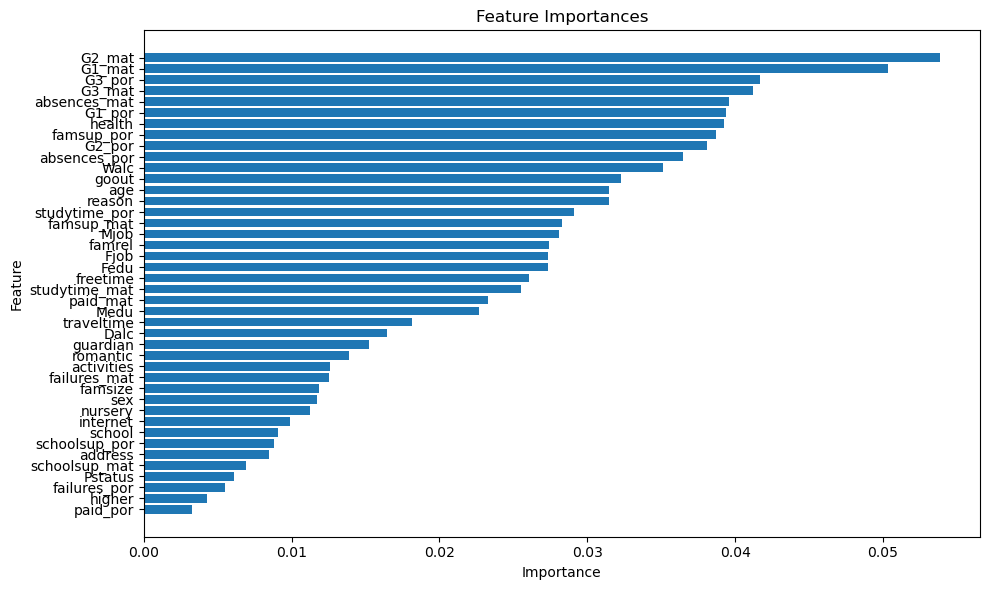


✅ Saved model as './dropout_predictor_model.pkl'


In [61]:
import os
import joblib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("student-dropout-fixed.csv")
output_path = "./"

# --- Encode categorical features ---
df_encoded = df.copy()
label_cols = df_encoded.select_dtypes(include='object').columns
encoders = {}
os.makedirs(os.path.join(output_path, "encoders"), exist_ok=True)

for col in label_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    encoders[col] = le
    joblib.dump(le, os.path.join(output_path, f"encoders/{col}_encoder.pkl"))

# --- Drop student_id and separate features and target ---
X = df_encoded.drop(["dropout", "student_id"], axis=1)
y = df_encoded["dropout"]

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Save X_train structure ---
X_train.to_csv(os.path.join(output_path, "X_train_structure.csv"), index=False)
print("✅ Saved 'X_train_structure.csv' for Streamlit alignment")

# --- Apply SMOTE ---
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("✅ Applied SMOTE")

# --- Hyperparameter Tuning with GridSearchCV ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],  # 'auto' removed
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    error_score='raise'  # Will raise errors for easier debugging
)
grid_search.fit(X_train_bal, y_train_bal)

print(f"Best parameters found by GridSearchCV: {grid_search.best_params_}")

# --- Train model using the best parameters ---
clf = grid_search.best_estimator_

# --- Evaluate ---
y_pred = clf.predict(X_test)
print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# --- ROC AUC Score ---
auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f"\n📈 ROC AUC Score: {auc_score:.2f}")

# --- Cross-validation ---
cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=5, scoring='accuracy')
print(f"\n📊 Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")

# --- Feature Importance Visualization ---
feature_importances = clf.feature_importances_
sorted_idx = feature_importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "feature_importances.png"))  # Save plot
plt.show()

# --- Save model ---
model_filename = "dropout_predictor_model.pkl"
model_path = os.path.join(output_path, model_filename)
joblib.dump(clf, model_path)
print(f"\n✅ Saved model as '{model_path}'")

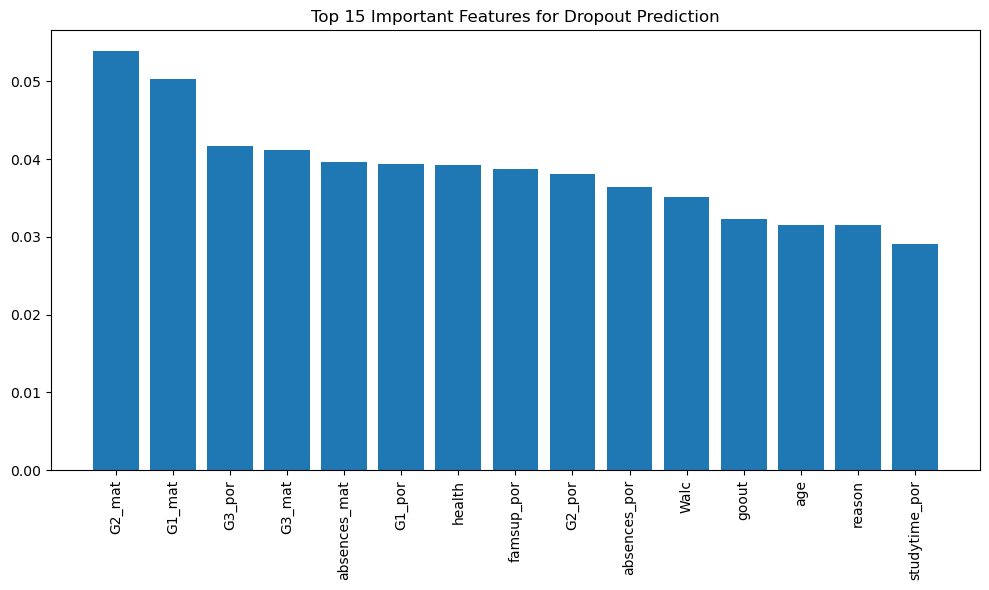

🔝 Top 15 Features Ranked by Importance:
          Feature  Importance
0          G2_mat    0.053869
1          G1_mat    0.050309
2          G3_por    0.041686
3          G3_mat    0.041217
4    absences_mat    0.039578
5          G1_por    0.039360
6          health    0.039263
7      famsup_por    0.038721
8          G2_por    0.038083
9    absences_por    0.036457
10           Walc    0.035150
11          goout    0.032280
12            age    0.031501
13         reason    0.031482
14  studytime_por    0.029131
✅ Top features saved to top_features.csv


In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

# --- Load your data and model ---
X = pd.read_csv("X_train_structure.csv")  # Your feature matrix
clf = joblib.load("dropout_predictor_model.pkl")  # Your trained model

# --- Step 1: Drop 'student_id' column if it exists ---
X_clean = X.drop(columns=['student_id'], errors='ignore')

# --- Step 2: Get feature importance scores from the trained model ---
importances = clf.feature_importances_

# --- Step 3: Sort feature importances in descending order ---
indices = np.argsort(importances)[::-1]

# --- Step 4: Ensure the indices do not exceed the number of available features ---
valid_indices = indices[indices < len(X_clean.columns)]
features = X_clean.columns

# --- Step 5: Ensure that the number of top features does not exceed the available features ---
top_n = min(15, len(X_clean.columns))

# --- Step 6: Plot the top N most important features ---
plt.figure(figsize=(10, 6))
plt.title(f"Top {top_n} Important Features for Dropout Prediction")
plt.bar(range(top_n), importances[valid_indices][:top_n], align="center")
plt.xticks(range(top_n), features[valid_indices][:top_n], rotation=90)
plt.tight_layout()
plt.savefig("top_features.png", dpi=300)
plt.show()

# --- Step 7: Create a DataFrame of the top N important features ---
important_features = pd.DataFrame({
    "Feature": features[valid_indices][:top_n],
    "Importance": importances[valid_indices][:top_n]
})

# --- Step 8: Print the DataFrame to review or report ---
print(f"🔝 Top {top_n} Features Ranked by Importance:")
print(important_features)

# --- Step 9: Save the top features to a file for later use ---
important_features["Feature"].to_csv("top_features.csv", index=False, header=False)
print("✅ Top features saved to top_features.csv")

In [65]:
import os
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# --- Define output path ---
output_path = "output"  # Replace with your desired path
os.makedirs(output_path, exist_ok=True)

# --- Load dataset ---
df = pd.read_csv("student-dropout-fixed.csv")

# --- Encode categorical features ---
df_encoded = df.copy()
label_cols = df_encoded.select_dtypes(include='object').columns
encoders = {}

# Save encoders for later use
encoder_dir = os.path.join(output_path, "encoders")
os.makedirs(encoder_dir, exist_ok=True)

for col in label_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le
    joblib.dump(le, os.path.join(encoder_dir, f"{col}_encoder.pkl"))

# --- Split into features and target ---
# Drop 'student_id' explicitly
X = df_encoded.drop(columns=["dropout", "student_id"], errors="ignore")
y = df_encoded["dropout"]

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Save X_train structure ---
X_train_structure_path = os.path.join(output_path, "X_train_structure.csv")
X_train.to_csv(X_train_structure_path, index=False)
print(f"✅ Saved 'X_train_structure.csv' for Streamlit alignment at {X_train_structure_path}")

# --- Apply SMOTE ---
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("✅ Applied SMOTE")

# --- Train model ---
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_bal, y_train_bal)

# --- Evaluate ---
y_pred = clf.predict(X_test)
print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# --- Save model ---
model_path = os.path.join(output_path, "dropout_predictor_model.pkl")
joblib.dump(clf, model_path)
print(f"✅ Saved model as '{model_path}'")

# --- Save test dataset structure for validation ---
X_test_structure_path = os.path.join(output_path, "X_test_structure.csv")
X_test.to_csv(X_test_structure_path, index=False)
print(f"✅ Saved 'X_test_structure.csv' for validation at {X_test_structure_path}")


✅ Saved 'X_train_structure.csv' for Streamlit alignment at output/X_train_structure.csv
✅ Applied SMOTE

📉 Confusion Matrix:
[[25 21]
 [10 21]]

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.54      0.62        46
           1       0.50      0.68      0.58        31

    accuracy                           0.60        77
   macro avg       0.61      0.61      0.60        77
weighted avg       0.63      0.60      0.60        77

✅ Saved model as 'output/dropout_predictor_model.pkl'
✅ Saved 'X_test_structure.csv' for validation at output/X_test_structure.csv


In [67]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Load your cleaned dataset
df = pd.read_csv("student-dropout-fixed.csv")  # Use the fixed dataset!

# Drop student_id before encoding (ensure student_id is excluded)
df_encoded = df.drop("student_id", axis=1).copy()

# Identify categorical columns
label_cols = df_encoded.select_dtypes(include='object').columns

# Assert no missing values in categorical columns
assert df_encoded[label_cols].isnull().sum().sum() == 0, "Missing values found — please handle first!"

# Handle missing values in numerical columns (if any)
numerical_cols = df_encoded.select_dtypes(exclude='object').columns
assert df_encoded[numerical_cols].isnull().sum().sum() == 0, "Missing values found in numerical columns — please handle first!"

# Create folder to save encoders
os.makedirs("encoders", exist_ok=True)

# Encode each categorical column and save encoder
encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le
    joblib.dump(le, f'encoders/{col}_encoder.pkl')

# Save encoded dataset to CSV for clustering or modeling
df_encoded.to_csv("student-encoded.csv", index=False)
print("✅ Encoded dataset saved as 'student-encoded.csv'")

# Optionally, save column names or other information for later use
joblib.dump(df_encoded.columns, "encoders/columns.pkl")
print("✅ Column names saved in 'encoders/columns.pkl'")


✅ Encoded dataset saved as 'student-encoded.csv'
✅ Column names saved in 'encoders/columns.pkl'


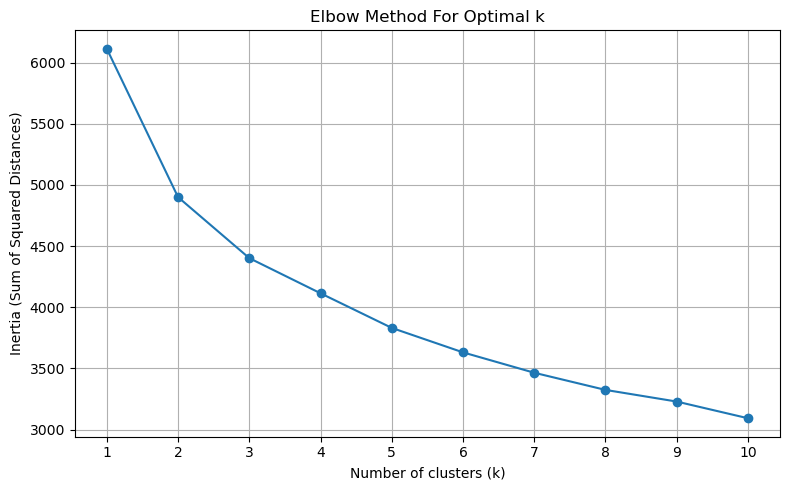

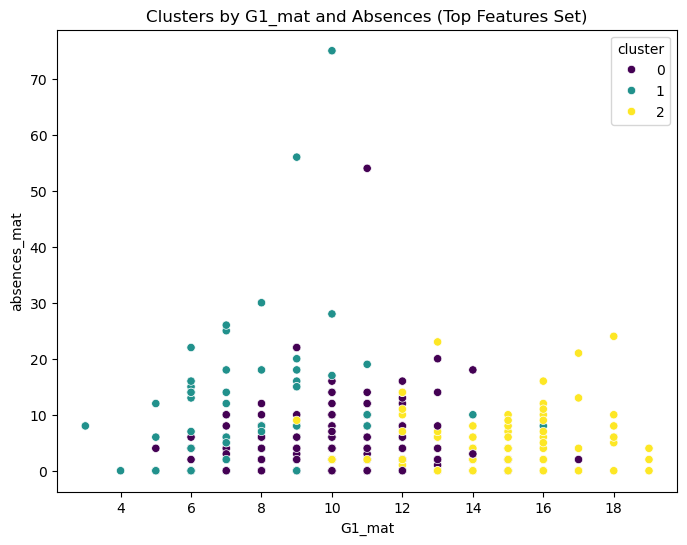

📊 Cluster Summary (Top Predictors):
         G1_mat  G2_mat  G3_mat  G1_por  G2_por  G3_por  studytime_mat  \
cluster                                                                  
0         10.05   10.22    9.79   11.59   11.68   12.12           2.06   
1          7.80    6.77    5.91    9.76    9.84    9.52           1.60   
2         14.58   14.59   14.86   14.80   15.04   15.50           2.32   

         studytime_por  absences_mat  absences_por  failures_mat  \
cluster                                                            
0                 2.06          4.38          2.38          0.05   
1                 1.60          8.58          7.59          1.17   
2                 2.34          4.35          2.79          0.01   

         failures_por  freetime  goout  health  traveltime  dropout  
cluster                                                              
0                0.01      3.15   3.08    3.50        1.41     0.37  
1                0.57      3.41   3.48    

In [78]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Load your fully encoded dataset ---
df_encoded = pd.read_csv("student-encoded.csv")  # replace with your encoded dataset filename

# --- Step 1: Select top 15 most important features based on earlier analysis ---
top_features = [
    "G1_mat", "G2_mat", "G3_mat", "G1_por", "G2_por", "G3_por",
    "studytime_mat", "studytime_por", "absences_mat", "absences_por",
    "failures_mat", "failures_por", "freetime", "goout", "health", "traveltime"
]

X_cluster = df_encoded[top_features]

# --- Step 2: Standardize the data for KMeans ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# --- Step 3: Elbow Method Visualization ---
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

os.makedirs("cluster_plots", exist_ok=True)
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.savefig("cluster_plots/elbow_method.png")
plt.show()

# --- Step 4: Apply KMeans clustering with 3 clusters (based on elbow method) ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_encoded["cluster"] = kmeans.fit_predict(X_scaled)

# --- Step 5: Save cluster assignments ---
df_encoded.to_csv("students_with_clusters.csv", index=False)

# --- Step 6: Visualize clusters with two key features ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_encoded, x="G1_mat", y="absences_mat", hue="cluster", palette="viridis")
plt.title("Clusters by G1_mat and Absences (Top Features Set)")
plt.savefig("cluster_plots/cluster_scatter_top_features.png")
plt.show()

# --- Step 7: Print cluster-level averages for analysis ---
cluster_summary = df_encoded.groupby("cluster")[top_features + ["dropout"]].mean().round(2)
print("📊 Cluster Summary (Top Predictors):")
print(cluster_summary)

In [80]:
####### Added to save the kmeans and scaler model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_encoded["cluster"] = kmeans.fit_predict(X_scaled)

# --- ADD THIS: ---
import joblib
joblib.dump(scaler, "scaler.pkl")
joblib.dump(kmeans, "kmeans.pkl")

['kmeans.pkl']

In [82]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib

# Load your encoded training data
X_train = pd.read_csv("X_train_structure.csv")

# Load the top features
with open("top_features.csv") as f:
    top_features = [line.strip() for line in f.readlines()]

# Fit scaler and kmeans on top features
X_cluster = X_train[top_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Save scaler and kmeans for later use
joblib.dump(scaler, "scaler.pkl")
joblib.dump(kmeans, "kmeans.pkl")

['kmeans.pkl']

In [84]:
import pandas as pd

# Assuming X_test and y_test contain the test data and target, and clf is your trained model

# --- Step 1: Get model predictions ---
y_pred = clf.predict(X_test)  # Get the predictions

# --- Step 2: Identify students who are predicted as high-risk (dropout = 1) ---
# Filter high-risk students where the prediction is 1
high_risk_indices = X_test.index[y_pred == 1]

# --- Step 3: Map high-risk students back to original dataset with student_id ---
# Assuming 'student_id' exists in the original dataset 'df' and it's encoded in the same way
high_risk_students_with_ids = df.loc[high_risk_indices, ['student_id', 'dropout']]

# --- Step 4: Print high-risk students and their IDs ---
print(f"🔍 Found {len(high_risk_students_with_ids)} high-risk students predicted by the model.")
print("\nHigh-Risk Students IDs:")
print(high_risk_students_with_ids)

# --- Step 5: Select one high-risk student to simulate interventions ---
# Pick the first high-risk student
sample = high_risk_students_with_ids.iloc[0].copy()

# Print the student ID of the selected high-risk student
selected_student_id = sample['student_id']
print(f"\n🎯 Selected High-Risk Student ID: {selected_student_id}")

# Now you can confirm the original prediction for this student
# Recreate the row from the encoded data for intervention simulation
sample_encoded = X_test.loc[sample.name]  # Extract the encoded row from X_test
sample_df = pd.DataFrame([sample_encoded], columns=X_test.columns)

# Confirm the original prediction
original_prediction = clf.predict(sample_df)[0]
print(f"🎯 Original Prediction: {original_prediction}")


🔍 Found 124 high-risk students predicted by the model.

High-Risk Students IDs:
     student_id  dropout
1             2        0
6             7        0
8             9        0
9            10        1
11           12        0
..          ...      ...
285         286        0
291         292        0
294         295        1
300         301        0
302         303        1

[124 rows x 2 columns]

🎯 Selected High-Risk Student ID: 2
🎯 Original Prediction: 1


In [6]:
import pandas as pd
import joblib
import numpy as np

# --- Load model, scaler, kmeans, and top features ---
clf = joblib.load("dropout_predictor_model.pkl")
scaler = joblib.load("scaler.pkl")
kmeans = joblib.load("kmeans.pkl")
with open("top_features.csv") as f:
    top_features = [line.strip() for line in f.readlines()]

# --- Load your test data ---
X_test = pd.read_csv("X_train_structure.csv")

# --- Predict high-risk students ---
y_pred = clf.predict(X_test)
high_risk_indices = X_test.index[y_pred == 1]
high_risk_students = X_test.loc[high_risk_indices].copy()

print(f"🔍 Found {len(high_risk_students)} high-risk students predicted by the model.")

# --- Assign clusters using the same top features ---
X_cluster = high_risk_students[top_features]
X_scaled = scaler.transform(X_cluster)
high_risk_students["cluster"] = kmeans.predict(X_scaled)

# --- Define cluster-based interventions (customize as needed) ---
cluster_interventions = {
    1: "Mentorship and motivational support to stay on track",
    2: "Intensive tutoring, attendance monitoring, and behavioral support to reduce dropout risk.",
    3: "Enrichment programs and university guidance to sustain engagement and growth.",
}
high_risk_students["intervention_suggestion"] = high_risk_students["cluster"].map(cluster_interventions)

# --- Show and/or save results ---
cols_to_show = ["cluster", "intervention_suggestion"]
if "student_id" in high_risk_students.columns:
    cols_to_show = ["student_id"] + cols_to_show

print("\n📋 High-risk students with cluster-based intervention suggestions:")
print(high_risk_students[cols_to_show].head())

high_risk_students[cols_to_show].to_csv("high_risk_cluster_interventions.csv", index=False)
print("✅ Intervention suggestions saved to high_risk_cluster_interventions.csv")

# --- Summary check for the first high-risk student ---
if not high_risk_students.empty:
    print("\n🎯 Original Prediction for the first high-risk student:")
    sample = high_risk_students.iloc[0].copy()
    sample_df = pd.DataFrame([sample], columns=X_test.columns)
    original_pred = clf.predict(sample_df)[0]
    print(f"🎯 Original Prediction: {original_pred}")

    # --- Define possible interventions for demonstration ---
    interventions = {
        "studytime_mat": 4,
        "absences_mat": 0,
        "failures_mat": 0,
        "G3_mat": 15,
        "G2_mat": 15,
        "G1_por": 15,
        "Walc": 1,  # Use 'Walc' if that's the correct column in your data
    }

    print("\n📊 Individual Intervention Outcomes:")
    for feature, new_value in interventions.items():
        if feature in sample.index:
            modified = sample.copy()
            modified[feature] = new_value
            modified_df = pd.DataFrame([modified], columns=X_test.columns)
            prediction = clf.predict(modified_df)[0]
            print(f"→ After setting {feature} = {new_value}: Prediction = {prediction}")

    # --- Combo intervention: set all at once ---
    combo_sample = sample.copy()
    for feature, value in interventions.items():
        if feature in combo_sample.index:
            combo_sample[feature] = value
    combo_df = pd.DataFrame([combo_sample], columns=X_test.columns)
    combo_prediction = clf.predict(combo_df)[0]
    print("\n🧪 Combo Intervention Prediction:", combo_prediction)
else:
    print("No high-risk students found for intervention simulation.")

🔍 Found 124 high-risk students predicted by the model.

📋 High-risk students with cluster-based intervention suggestions:
    cluster                            intervention_suggestion
1         0                                                NaN
6         2  Intensive tutoring, attendance monitoring, and...
8         0                                                NaN
9         2  Intensive tutoring, attendance monitoring, and...
11        0                                                NaN
✅ Intervention suggestions saved to high_risk_cluster_interventions.csv

🎯 Original Prediction for the first high-risk student:
🎯 Original Prediction: 1

📊 Individual Intervention Outcomes:
→ After setting studytime_mat = 4: Prediction = 1
→ After setting absences_mat = 0: Prediction = 1
→ After setting failures_mat = 0: Prediction = 1
→ After setting G3_mat = 15: Prediction = 1
→ After setting G2_mat = 15: Prediction = 1
→ After setting G1_por = 15: Prediction = 1
→ After setting Walc = 1: Pred